## Imports
---

In [ ]:
#external
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

#sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score 
from sklearn.metrics import recall_score, confusion_matrix, roc_auc_score, roc_curve, auc

#oversampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

#utils
from src.utils.dataset import get_full_transactions_dataset 

2025-03-05 18:28:24.464 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-03-05 18:28:24.466 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-03-05 18:28:24.466 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


## Dataset
---

In [2]:
df = get_full_transactions_dataset().sample(50000)

2025-03-05 18:28:24.475 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-03-05 18:28:24.476 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-05 18:28:25.082 
  command:

    streamlit run C:\Users\ferna\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-03-05 18:28:25.084 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-05 18:28:25.084 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-05 18:28:25.600 Thread 'Thread-5': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-05 18:28:25.613 Thread 'Thread-5': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-05 18:28:32.802 Thread 'Ma

In [3]:
df.dtypes

timestamp              object
sender                 object
receiver               object
amount_received       float64
receiving_currency     object
amount_paid           float64
payment_currency       object
payment_format         object
is_laundering           int64
dtype: object

In [4]:
df.isna().sum()

timestamp             0
sender                0
receiver              0
amount_received       0
receiving_currency    0
amount_paid           0
payment_currency      0
payment_format        0
is_laundering         0
dtype: int64

In [5]:
df.head()

,timestamp,sender,receiver,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
3699746,2022/09/07 22:03,25337_80A78E7B0,22758_813FF1550,273.14,Euro,273.14,Euro,Cheque,0
2527957,2022/09/05 11:43,1412_801A38370,233168_810236970,2029.98,US Dollar,2029.98,US Dollar,Credit Card,0
4348093,2022/09/09 04:07,138335_80E54A3A0,238845_80E8388A0,5579.61,Swiss Franc,5579.61,Swiss Franc,Cheque,0
2033320,2022/09/03 18:36,1467_80033D290,5140_8067C5290,292.89,US Dollar,292.89,US Dollar,Cheque,0
4795263,2022/09/09 21:14,44797_810C8D1A0,4503_814397CF0,693.32,US Dollar,693.32,US Dollar,Credit Card,0


In [6]:
df.is_laundering.value_counts(True)

is_laundering
0    0.99878
1    0.00122
Name: proportion, dtype: float64

## Tranformations
---

In [7]:
def custom_transformations(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe = dataframe.drop(columns=["sender", "receiver"])
    dataframe["timestamp"] = pd.to_datetime(dataframe["timestamp"])
    dataframe["timestamp"] = dataframe["timestamp"].apply(lambda timestamp_value: timestamp_value.value)
    return dataframe

In [8]:
df = custom_transformations(df)

## Defining pipeline
---

In [9]:
X = df.drop(columns=["is_laundering"])
y = df["is_laundering"]

In [10]:
categorical_columns = X.select_dtypes(include="object").columns
numerical_columns = X.select_dtypes(exclude="object").columns

In [11]:
numerical_pipeline = Pipeline([
    ("scaler", RobustScaler())
])

categorical_pipeline = Pipeline([
    ("encoder", OrdinalEncoder())
])

preprocess = ColumnTransformer([
    ("numerical_pipeline", numerical_pipeline, numerical_columns),
    ("categorical_pipeline", categorical_pipeline, categorical_columns)
])

## Train
---

### Train & Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
y_train.value_counts(True), y_test.value_counts(True) 

In [ ]:
X_train = preprocess.fit_transform(X_train)
X_test = preprocess.transform(X_test)

### Oversampling (SMOTE)

In [ ]:
oversample = SMOTE(random_state=42, sampling_strategy=0.5)
X_train_resample, y_train_resample = oversample.fit_resample(X_train, y_train)

In [ ]:
y_train_resample.value_counts(), y_test.value_counts() 

### Grid search

In [ ]:
grid_parameter = {
    "max_depth": [4, 8, 16],
    "n_estimators": [100, 200, 300],
    "max_features": [20, 40, 80]
}

In [ ]:
grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=grid_parameter,
    cv=3,
    scoring="roc_auc", 
    verbose=3)

model_grid = grid.fit(X_train_resample, y_train_resample)

print(f"Best parameters: {model_grid.best_params_}")
print(f"Best score is: {model_grid.best_score_}")

Best parameters: {'max_depth': 16, 'max_features': 20, 'n_estimators': 300}

## Testing best model

In [12]:
full_dataframe = get_full_transactions_dataset()

In [13]:
fraud_transactions_df = full_dataframe[full_dataframe["is_laundering"] == 1]
non_fraud_transactions_df = full_dataframe[full_dataframe["is_laundering"] == 0].sample(int(50e3))
sample_dataframe = pd.concat([fraud_transactions_df, non_fraud_transactions_df])

In [14]:
sample_dataframe.is_laundering.value_counts()

is_laundering
0    50000
1     5177
Name: count, dtype: int64

In [15]:
sample_dataframe.shape[0]

55177

In [16]:
sample_dataframe = custom_transformations(sample_dataframe)

In [17]:
X = sample_dataframe.drop(columns=["is_laundering"])
y = sample_dataframe["is_laundering"]

In [ ]:
full_pipeline = ImbPipeline([
    ("preprocess", preprocess), 
    ("smote", SMOTE(random_state=42, sampling_strategy=1)),
    ("model", RandomForestClassifier(max_depth=16, max_features=20, n_estimators=300, random_state=42))
])

In [19]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [20]:
cross_validation_result = cross_validate(
    full_pipeline,
    X,
    y,
    cv=cv,
    scoring=("f1", "accuracy", "roc_auc"),
    verbose=3
)

[CV] END  accuracy: (test=0.931) f1: (test=0.684) roc_auc: (test=0.913) total time=  54.2s
[CV] END  accuracy: (test=0.933) f1: (test=0.690) roc_auc: (test=0.920) total time=  54.5s
[CV] END  accuracy: (test=0.937) f1: (test=0.700) roc_auc: (test=0.919) total time=  54.6s


## Evaluate

In [21]:
y_pred = cross_val_predict(full_pipeline, X, y, cv=cv)
y_pred_prob = cross_val_predict(full_pipeline, X, y, cv=cv, method='predict_proba')[:, 1]

In [22]:
acc = accuracy_score(y, y_pred)
print(f'Accuracy: {acc:.4f}')

f1 = f1_score(y, y_pred)  
print(f'F1 Score: {f1:.4f}')

precision = precision_score(y, y_pred)
print(f'Precision: {precision:.4f}')

recall = recall_score(y, y_pred)
print(f'Recall: {recall:.4f}')

auc_score = roc_auc_score(y, y_pred_prob)
print(f'AUC: {auc_score:.4f}')

Accuracy: 0.9338
F1 Score: 0.6912
Precision: 0.6143
Recall: 0.7902
AUC: 0.9171


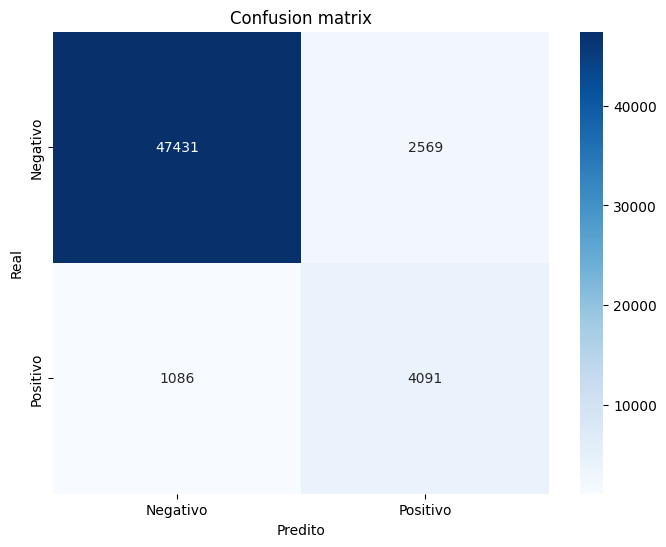

In [35]:
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title('Confusion matrix')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

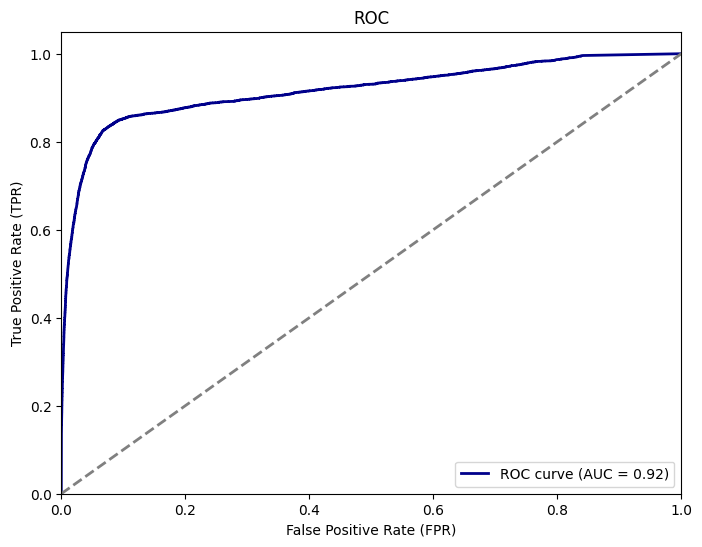

In [29]:
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkblue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [31]:
distances = np.sqrt(fpr**2 + (1 - tpr)**2)
best_threshold_idx = np.argmin(distances)
best_threshold = thresholds[best_threshold_idx]
print(f'O melhor limiar (threshold) é {best_threshold:.4f}')

O melhor limiar (threshold) é 0.1882


In [32]:
y_pred_adjusted = (y_pred_prob >= best_threshold).astype(int)

In [33]:
acc = accuracy_score(y, y_pred_adjusted)
print(f'Accuracy: {acc:.4f}')

f1 = f1_score(y, y_pred_adjusted)  
print(f'F1 Score: {f1:.4f}')

precision = precision_score(y, y_pred_adjusted)
print(f'Precision: {precision:.4f}')

recall = recall_score(y, y_pred_adjusted)
print(f'Recall: {recall:.4f}')

Accuracy: 0.9020
F1 Score: 0.6193
Precision: 0.4874
Recall: 0.8491


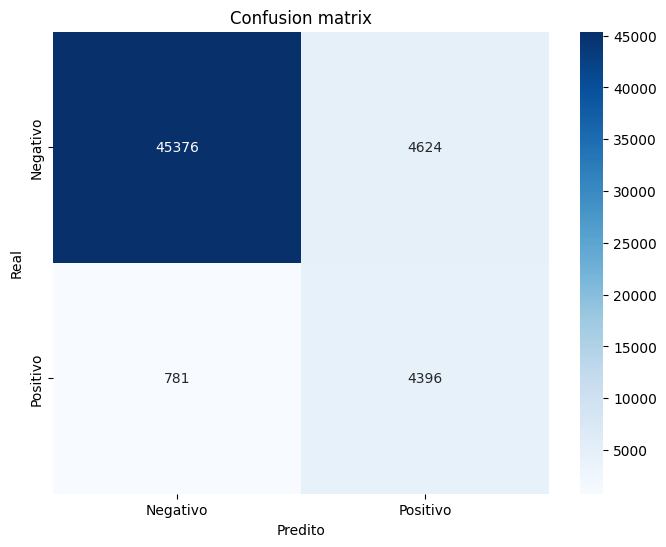

In [36]:
cm = confusion_matrix(y, y_pred_adjusted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title('Confusion matrix')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()